# Split Data Sampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

## Load Data

In [2]:
data_clean = "data_clean.csv"
data_results = "data_results.csv"
sampling = [1, 0.9, 0.7, 0.5, 0.3, 0.1]
splits = [0.9, 0.8, 0.7, 0.6, 0.5]
rand_split = 44

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df = pd.read_csv(data_clean, low_memory=False)
df.shape

(894609, 19)

## Load Models

In [4]:
models = [
    ("lr", LogisticRegression(C=1, penalty="l2", random_state=rand_split, max_iter=1000)),
    ("knn", KNeighborsClassifier(n_neighbors=10, weights="uniform", metric="manhattan")),
    ("dtc", DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=rand_split)),
    ("rfc", RandomForestClassifier(criterion="entropy", max_depth=20, random_state=rand_split)),
    ("xgb", XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=rand_split))
]

In [5]:
lr_cols = list(df.drop(columns=[target]).columns)
knn_cols = ["State","DifState","Sector","AppYear","Term","Secured","Urban","RevLine","LowDoc","SecuredSBA"]
dtc_cols = ["State","BankState","DifState","AppYear","Term","NoEmp","GrDisburs","ApprovSBA","SecuredSBA"]
rfc_cols = ["State","BankState","Sector","AppYear","Term","GrDisburs","GrApprov","ApprovSBA","SecuredSBA"]
xgb_cols = list(df.drop(columns=[target]).columns)

## Split Data

In [6]:
def ZScore(X_train, X_test):
    scaler = StandardScaler()

    X_train_std = X_train.copy()
    X_test_std = X_test.copy()

    X_train_std[num_cols] = scaler.fit_transform(X_train_std[num_cols])
    X_test_std[num_cols] = scaler.fit_transform(X_test_std[num_cols])

    return X_train_std, X_test_std

In [7]:
def MinMax(X_train, X_test):
    scaler = MinMaxScaler()

    X_train_nrm = X_train.copy()
    X_test_nrm = X_test.copy()

    X_train_nrm[num_cols] = scaler.fit_transform(X_train_nrm[num_cols])
    X_test_nrm[num_cols] = scaler.fit_transform(X_test_nrm[num_cols])

    return X_train_nrm, X_test_nrm

In [8]:
cols = ["Model","Sample","Split","Metric","Value"]
results = pd.DataFrame(columns=cols)

for samp in sampling:
    df_ = df.sample(frac=samp, random_state=rand_split)
    X = df_.drop(columns=[target])
    y = df_[target]

    for split in splits:
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            train_size=split,
                                                            random_state=rand_split)

        print(f"{samp} - {split}: ({X_train.shape[0]}, {X_test.shape[0]})...")

        X_train_std, X_test_std = ZScore(X_train, X_test)
        X_train_nrm, X_test_nrm = MinMax(X_train, X_test)

        mod_met = []

        y_lr = models[0][1].fit(X_train_std[lr_cols], y_train).predict(X_test_std[lr_cols])
        mod_met.append(["LR", samp, split, "Accuracy", (accuracy_score(y_test, y_lr))])
        mod_met.append(["LR", samp, split, "Precision", (precision_score(y_test, y_lr, average="macro"))])
        mod_met.append(["LR", samp, split, "Recall", (recall_score(y_test, y_lr, average="macro"))])
        mod_met.append(["LR", samp, split, "F1-Score", (f1_score(y_test, y_lr, average="macro"))])
        mod_met.append(["LR", samp, split, "AUC", (roc_auc_score(y_test, y_lr, average="macro"))])

        y_knn = models[1][1].fit(X_train_nrm[knn_cols], y_train).predict(X_test_nrm[knn_cols])
        mod_met.append(["KNN", samp, split, "Accuracy", (accuracy_score(y_test, y_knn))])
        mod_met.append(["KNN", samp, split, "Precision", (precision_score(y_test, y_knn, average="macro"))])
        mod_met.append(["KNN", samp, split, "Recall", (recall_score(y_test, y_knn, average="macro"))])
        mod_met.append(["KNN", samp, split, "F1-Score", (f1_score(y_test, y_knn, average="macro"))])
        mod_met.append(["KNN", samp, split, "AUC", (roc_auc_score(y_test, y_knn, average="macro"))])

        y_dtc = models[2][1].fit(X_train[dtc_cols], y_train).predict(X_test[dtc_cols])
        mod_met.append(["DTC", samp, split, "Accuracy", (accuracy_score(y_test, y_dtc))])
        mod_met.append(["DTC", samp, split, "Precision", (precision_score(y_test, y_dtc, average="macro"))])
        mod_met.append(["DTC", samp, split, "Recall", (recall_score(y_test, y_dtc, average="macro"))])
        mod_met.append(["DTC", samp, split, "F1-Score", (f1_score(y_test, y_dtc, average="macro"))])
        mod_met.append(["DTC", samp, split, "AUC", (roc_auc_score(y_test, y_dtc, average="macro"))])

        y_rfc = models[3][1].fit(X_train[rfc_cols], y_train).predict(X_test[rfc_cols])
        mod_met.append(["RFC", samp, split, "Accuracy", (accuracy_score(y_test, y_rfc))])
        mod_met.append(["RFC", samp, split, "Precision", (precision_score(y_test, y_rfc, average="macro"))])
        mod_met.append(["RFC", samp, split, "Recall", (recall_score(y_test, y_rfc, average="macro"))])
        mod_met.append(["RFC", samp, split, "F1-Score", (f1_score(y_test, y_rfc, average="macro"))])
        mod_met.append(["RFC", samp, split, "AUC", (roc_auc_score(y_test, y_rfc, average="macro"))])

        y_xgb = models[4][1].fit(X_train[xgb_cols], y_train).predict(X_test[xgb_cols])
        mod_met.append(["XGB", samp, split, "Accuracy", (accuracy_score(y_test, y_xgb))])
        mod_met.append(["XGB", samp, split, "Precision", (precision_score(y_test, y_xgb, average="macro"))])
        mod_met.append(["XGB", samp, split, "Recall", (recall_score(y_test, y_xgb, average="macro"))])
        mod_met.append(["XGB", samp, split, "F1-Score", (f1_score(y_test, y_xgb, average="macro"))])
        mod_met.append(["XGB", samp, split, "AUC", (roc_auc_score(y_test, y_xgb, average="macro"))])

        results = pd.concat([results, pd.DataFrame(mod_met, columns=cols)], ignore_index=True)

1 - 0.9: (805148, 89461)...
1 - 0.8: (715687, 178922)...
1 - 0.7: (626226, 268383)...
1 - 0.6: (536765, 357844)...
1 - 0.5: (447304, 447305)...
0.9 - 0.9: (724633, 80515)...
0.9 - 0.8: (644118, 161030)...
0.9 - 0.7: (563603, 241545)...
0.9 - 0.6: (483088, 322060)...
0.9 - 0.5: (402574, 402574)...
0.7 - 0.9: (563603, 62623)...
0.7 - 0.8: (500980, 125246)...
0.7 - 0.7: (438358, 187868)...
0.7 - 0.6: (375735, 250491)...
0.7 - 0.5: (313113, 313113)...
0.5 - 0.9: (402573, 44731)...
0.5 - 0.8: (357843, 89461)...
0.5 - 0.7: (313112, 134192)...
0.5 - 0.6: (268382, 178922)...
0.5 - 0.5: (223652, 223652)...
0.3 - 0.9: (241544, 26839)...
0.3 - 0.8: (214706, 53677)...
0.3 - 0.7: (187868, 80515)...
0.3 - 0.6: (161029, 107354)...
0.3 - 0.5: (134191, 134192)...
0.1 - 0.9: (80514, 8947)...
0.1 - 0.8: (71568, 17893)...
0.1 - 0.7: (62622, 26839)...
0.1 - 0.6: (53676, 35785)...
0.1 - 0.5: (44730, 44731)...


In [9]:
results.to_csv(data_results, index=False)
# results = pd.read_csv(data_results, low_memory=False)
results

,Model,Sample,Split,Metric,Value
0,LR,1,0.9,Accuracy,0.853567
1,LR,1,0.9,Precision,0.782796
2,LR,1,0.9,Recall,0.639734
3,LR,1,0.9,F1-Score,0.671870
4,LR,1,0.9,AUC,0.639734
...,...,...,...,...,...
745,XGB,0.1,0.5,Accuracy,0.946279
746,XGB,0.1,0.5,Precision,0.915029
747,XGB,0.1,0.5,Recall,0.896799
748,XGB,0.1,0.5,F1-Score,0.905558


In [10]:
df_data = results[["Model","Split","Value"]]\
                 [(results["Sample"] == 0.7) &
                  (results["Metric"] == "Accuracy")]

df_data.pivot_table(columns=["Split"],
                    index=["Model"],
                    values=["Value"],
                    aggfunc="mean")#.reset_index()

Value                                        
Split       0.5       0.6       0.7       0.8       0.9
Model                                                  
DTC    0.932698  0.934784  0.936189  0.936764  0.936605
KNN    0.865470  0.867652  0.868663  0.869633  0.864267
LR     0.855937  0.856143  0.855888  0.855516  0.855149
RFC    0.947150  0.947942  0.948432  0.949108  0.949252
XGB    0.952570  0.952314  0.953414  0.954450  0.955208

## Graphic Results

In [11]:
metric = "F1-Score"
df_data = results[["Sample","Model","Split","Value"]][results["Metric"] == metric]
df_data.sample(3)

,Sample,Model,Split,Value
398,0.5,XGB,0.9,0.920925
568,0.3,RFC,0.7,0.904247
338,0.7,DTC,0.6,0.886848


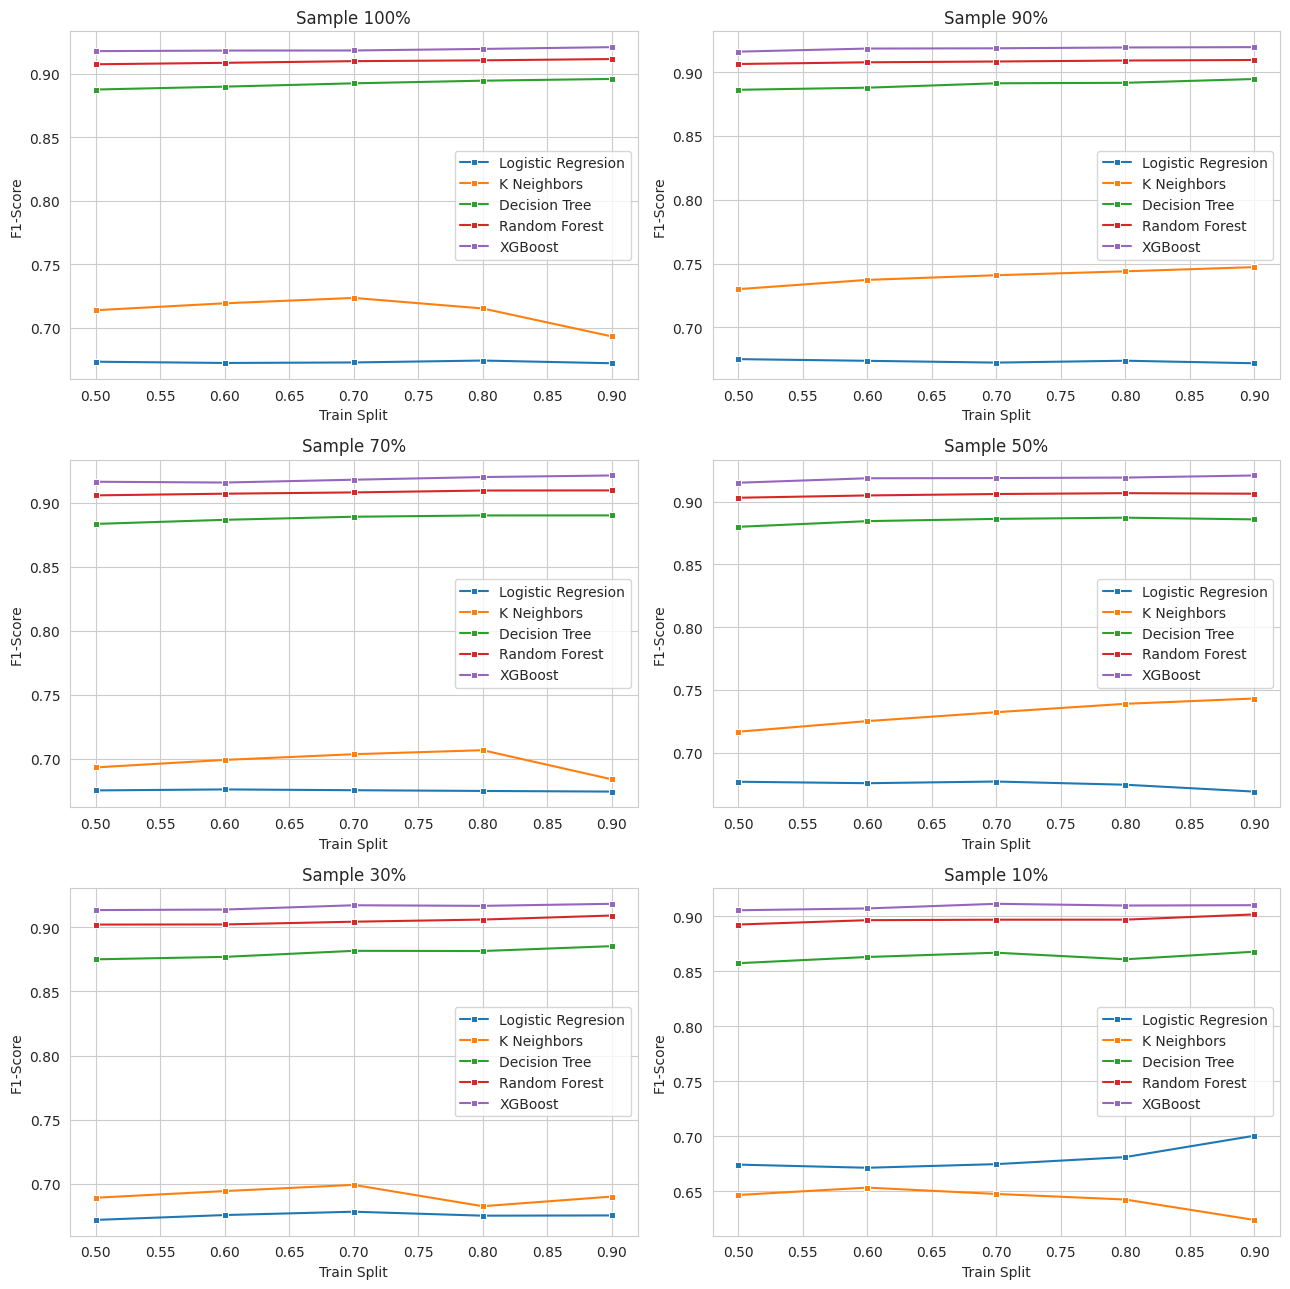

In [13]:
plt.figure(figsize=(13,13))
sns.set_style("whitegrid")
n_rows, n_cols = 3, 2

for num, sam in enumerate(sampling):
    plt.subplot(n_rows, n_cols, num + 1)
    plt.title(f"Sample {round(sam * 100)}%")
    plt.xlabel("Train Split")
    plt.ylabel(metric)

    sns.lineplot(data=df_data[(df_data["Sample"]==sam) & (df_data["Model"]=="LR")], x="Split", y="Value", label="Logistic Regresion", linewidth=1.5, linestyle="-", marker="s", markersize=4)
    sns.lineplot(data=df_data[(df_data["Sample"]==sam) & (df_data["Model"]=="KNN")], x="Split", y="Value", label="K Neighbors", linewidth=1.5, linestyle="-", marker="s", markersize=4)
    sns.lineplot(data=df_data[(df_data["Sample"]==sam) & (df_data["Model"]=="DTC")], x="Split", y="Value", label="Decision Tree", linewidth=1.5, linestyle="-", marker="s", markersize=4)
    sns.lineplot(data=df_data[(df_data["Sample"]==sam) & (df_data["Model"]=="RFC")], x="Split", y="Value", label="Random Forest", linewidth=1.5, linestyle="-", marker="s", markersize=4)
    sns.lineplot(data=df_data[(df_data["Sample"]==sam) & (df_data["Model"]=="XGB")], x="Split", y="Value", label="XGBoost", linewidth=1.5, linestyle="-", marker="s", markersize=4)

plt.legend()
plt.tight_layout()
plt.show()